In [4]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%reload_ext autoreload

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## Data Exploration
- Label distribution (by pitch, major/minor, and combined root pitch and major/minor)
- chroma energy values
- Relationship between labels and chroma energy values

In [6]:
data = pd.read_csv('data/chord_data.csv', header=None)

In [9]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000,40738.000000
mean,5.229147,0.218199,1.339436,0.860223,1.103861,1.156500,0.822990,1.292707,0.750032,1.253293,0.974080,0.913297,1.237724,0.776454
std,3.452830,0.413028,1.137390,0.961125,1.018418,1.161926,0.835085,1.148956,0.847559,1.076554,1.023538,0.879474,1.115191,0.819962
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.461000,0.277000,0.392000,0.316000,0.285000,0.414000,0.247000,0.430000,0.298000,0.316000,0.396000,0.284000
50%,5.000000,0.000000,0.933000,0.495000,0.731000,0.657000,0.523000,0.881000,0.450000,0.878000,0.552000,0.593000,0.803000,0.491000
75%,8.000000,0.000000,1.980000,0.975000,1.500000,1.710000,1.020000,1.920000,0.858000,1.870000,1.270000,1.200000,1.850000,0.897000
max,11.000000,1.000000,6.470000,6.520000,6.200000,6.470000,6.300000,7.050000,6.890000,6.720000,6.610000,5.760000,6.290000,6.190000


There are 40738 samples in the dataset, and chroma values range from 0 to ~7.0.
Some pitches have a larger range of chroma values, while some have higher 50th/70th percentile values, which might mean that they are more commonly activated than others.

In [10]:
data[0].value_counts()

0
5     5087
3     5047
10    4932
0     4863
7     4013
8     3933
1     2931
2     2709
9     2033
6     1854
11    1780
4     1556
Name: count, dtype: int64

In [11]:
data[1].value_counts()

1
0    31849
1     8889
Name: count, dtype: int64

In [30]:
# map index to chord
chords = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
chord_map = {i: chord for i, chord in enumerate(chords)}
majmin_map = {0: 'maj', 1: 'min'}
chord_majmin_map = {i: chord_map[i // 2] + majmin_map[i % 2] for i in range(24)}

([<matplotlib.axis.XTick at 0x13787a7c0>,
 [Text(0, 0, 'A'),
  Text(1, 0, 'A#'),
  Text(2, 0, 'B'),
  Text(3, 0, 'C'),
  Text(4, 0, 'C#'),
  Text(5, 0, 'D'),
  Text(6, 0, 'D#'),
  Text(7, 0, 'E'),
  Text(8, 0, 'F'),
  Text(9, 0, 'F#'),
  Text(10, 0, 'G'),
  Text(11, 0, 'G#')])

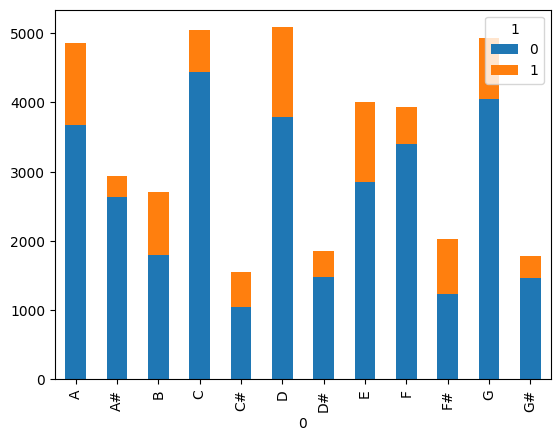

In [58]:
data.groupby([0, 1]).size().unstack().plot(kind='bar', stacked=True)
plt.xticks(np.arange(12), chords)

### Initial observations:
- There are far more Major chords than Minor chords.
- There are way more A/C/D/G chords than C#/D#/F#/G# chords.

Given the highly skewed labels, we need to ensure that our dataset is stratified during train-test split later.
We'd also want to explore the chord-level accuracies of our predictions, to make sure that less-represented chords are also predicted properly.


## Plot chroma values against chord labels

Text(0, 0.5, 'Chord')

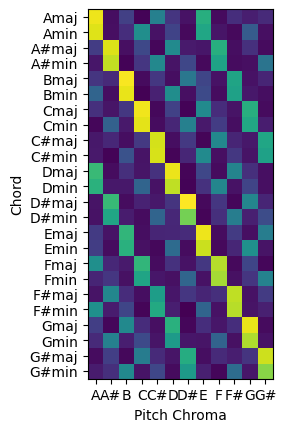

In [158]:
# plot average energy per chroma per chord
plt.imshow(data.groupby([0, 1]).mean(), cmap='viridis', interpolation='nearest',)
plt.xticks(np.arange(12), chords)
plt.yticks(np.arange(24), chord_majmin_map.values())
plt.xlabel('Pitch Chroma')
plt.ylabel('Chord')

Based on the Average (mean) energy level above, the root pitch has highest energy, while the other 2 pitches of its triad have the next highest energies.

Text(0, 0.5, 'Chord')

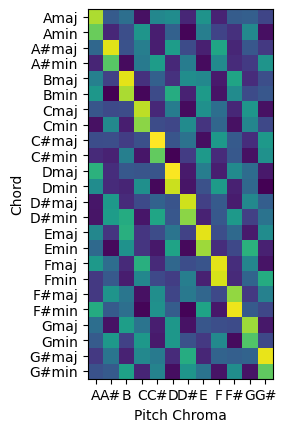

In [157]:
# plot standard deviation of energy per chroma per chord
plt.imshow(data.groupby([0, 1]).std(), cmap='viridis', interpolation='nearest',)
plt.xticks(np.arange(12), chords)
plt.yticks(np.arange(24), chord_majmin_map.values())
plt.xlabel('Pitch Chroma')
plt.ylabel('Chord')

The standard deviation of each chroma is surprisingly higher at the root pitch, suggesting that the root pitch alone might be insufficient to determine a chord. Some chords might have lower energies at their root pitch.

## Train-Test Split

In [62]:
from sklearn.model_selection import train_test_split

In [60]:
X = data.loc[:, 2:]
y = data.loc[:, 0:1]

In [173]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

### Check if:
- Train and test shape is 70/30% of dataset
- Chord distribution is retained in both the train and test sets

In [174]:
X_train.shape, X_test.shape

((28516, 12), (12222, 12))

In [175]:
y_train.value_counts(normalize=True)

0   1
3   0    0.109097
10  0    0.099418
5   0    0.092895
0   0    0.090265
8   0    0.083567
7   0    0.069926
1   0    0.064525
2   0    0.043940
6   0    0.036295
11  0    0.035980
5   1    0.031982
9   0    0.030159
0   1    0.029106
7   1    0.028580
4   0    0.025775
2   1    0.022549
10  1    0.021637
9   1    0.019743
3   1    0.014764
8   1    0.012975
4   1    0.012414
6   1    0.009223
11  1    0.007750
1   1    0.007434
Name: proportion, dtype: float64

In [176]:
y_test.value_counts(normalize=True)

0   1
3   0    0.109147
10  0    0.099411
5   0    0.092865
0   0    0.090247
8   0    0.083538
7   0    0.069956
1   0    0.064474
2   0    0.043937
6   0    0.036246
11  0    0.035919
5   1    0.031991
9   0    0.030191
0   1    0.029128
7   1    0.028555
4   0    0.025773
2   1    0.022582
10  1    0.021682
9   1    0.019719
3   1    0.014809
8   1    0.013009
4   1    0.012437
6   1    0.009246
11  1    0.007691
1   1    0.007446
Name: proportion, dtype: float64

In [177]:
y.value_counts(normalize=True)

0   1
3   0    0.109112
10  0    0.099416
5   0    0.092886
0   0    0.090260
8   0    0.083558
7   0    0.069935
1   0    0.064510
2   0    0.043939
6   0    0.036281
11  0    0.035962
5   1    0.031985
9   0    0.030168
0   1    0.029113
7   1    0.028573
4   0    0.025774
2   1    0.022559
10  1    0.021651
9   1    0.019736
3   1    0.014777
8   1    0.012985
4   1    0.012421
6   1    0.009230
11  1    0.007732
1   1    0.007438
Name: proportion, dtype: float64

## Chroma Template-based Chord Identification

### Create chroma template
- Create binary map using the top 3 pitches per chord label,to get a map of each chord's triad

In [79]:
avg_chroma = data.groupby([0, 1]).mean().values
# Generate binary map for top 3 indices for each row to get chords in triads
mask = np.zeros_like(avg_chroma)
for i in range(avg_chroma.shape[0]):
    mask[i, np.argsort(avg_chroma[i])[-3:]] = 1
    

Text(0, 0.5, 'Chord')

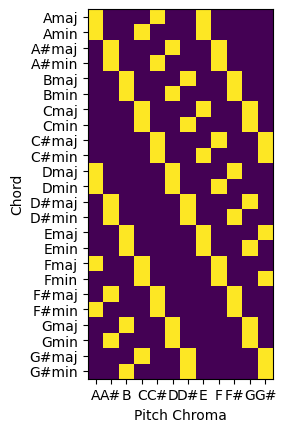

In [159]:
# plot binary map with legend
plt.imshow(mask, cmap='viridis', interpolation='nearest',)
plt.xticks(np.arange(12), chords)
plt.yticks(np.arange(24), chord_majmin_map.values())
plt.xlabel('Pitch Chroma')
plt.ylabel('Chord')

### Define similarity metric and helper functions
- We use a normalized inner product to calculate the similarity between the chord map and a given chroma feature

We also need functions for:
- Converting 2-column labels into an index label (0-23)
- Make predictions for each chord

In [99]:
# Calculate normalized inner product between 2 vectors
def inner_product(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [165]:
def convert_label_to_idx(chord_idx, majmin_idx):
    label = chord_idx * 2 + majmin_idx
    return label

In [148]:
def predict_chord(mask, chroma):
    similarity_scores = []
    # normalize chroma vector
    chroma = chroma / np.linalg.norm(chroma)
    for i in range(mask.shape[0]):
        similarity_scores.append(inner_product(chroma, mask[i]))
    return similarity_scores, np.argmax(similarity_scores)


In [169]:
similarity_scores, pred = predict_chord(mask, data.iloc[0, 2:].values)

In [170]:
convert_label_to_idx(*data.iloc[0, :2])

2.0

In [171]:
pred

np.int64(2)

In [172]:
simliarity

[np.float64(0.04741484942122166),
 np.float64(0.2620413306228687),
 np.float64(0.6495317587607408),
 np.float64(0.6138414259198348),
 np.float64(0.21890609124818103),
 np.float64(0.06580909788538088),
 np.float64(0.40825864896746716),
 np.float64(0.5749211987041863),
 np.float64(0.19443964135950575),
 np.float64(0.048771405058613555),
 np.float64(0.07470745688779679),
 np.float64(0.22877341856301978),
 np.float64(0.786479280249828),
 np.float64(0.648562790448318),
 np.float64(0.04529926860576524),
 np.float64(0.19016003131297177),
 np.float64(0.40770956692376087),
 np.float64(0.4090661225611528),
 np.float64(0.45977546424461196),
 np.float64(0.03901712404689084),
 np.float64(0.20372558768689075),
 np.float64(0.6333822868870277),
 np.float64(0.4300604359969798),
 np.float64(0.21196181834248443)]

### Define evaluation function
- Accuracy (i.e. whether predicted label == true label)
- Root pitch accuracy (i.e. whether predicted root note == true root note, ignoring maj/min)

In [190]:
def evaluate(y_true, y_pred):
    acc = np.mean(y_true == y_pred)
    pitch_acc = np.mean(y_true//2 == y_pred//2)
    return acc, pitch_acc

In [182]:
y_true_idx = data.apply(lambda x: convert_label_to_idx(*x[:2]), axis=1)  

In [187]:
y_pred_idx = data.apply(lambda x: predict_chord(mask, x[2:])[1], axis=1)  

In [189]:
np.mean(y_true_idx == y_pred_idx)

np.float64(0.7693553929991654)

In [ ]:
y_true_idx[:, 0]

In [191]:
evaluate(y_true_idx, y_pred_idx)

(np.float64(0.7693553929991654), np.float64(0.8016102901467917))